# House price competition: pipeline and models.

If you already know how to bluid basic-machine learning algorithms, observe and clean the data you are dealing with, you might want to go to the next level and start implementing pipelines in your codes.
The principal goal of building a pipeline is to make things easier, more understandable and it's a proper way to avoid data leakage.

In this tutorial, i'll try to present what I've learned to build simple and effective pipelines in order to finetune every kind of models.

However, since I am not an expert myself, I'd be glad to hear your recommandations in the comment section !

A huge part of this notebook comes from the excellent [Serigne notebook](http://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard). I highly suggest to check it first. My intend here is to re-use its work on the feature engineering to focus more on the creation of a pipeline.

Moreover, since I'll build many different types of estimators through this notebook, I'll try to explain the main ideas of each so that you might learn more things !

One last thing: please consider leaving an upvote if you find this notebook useful in any ways !

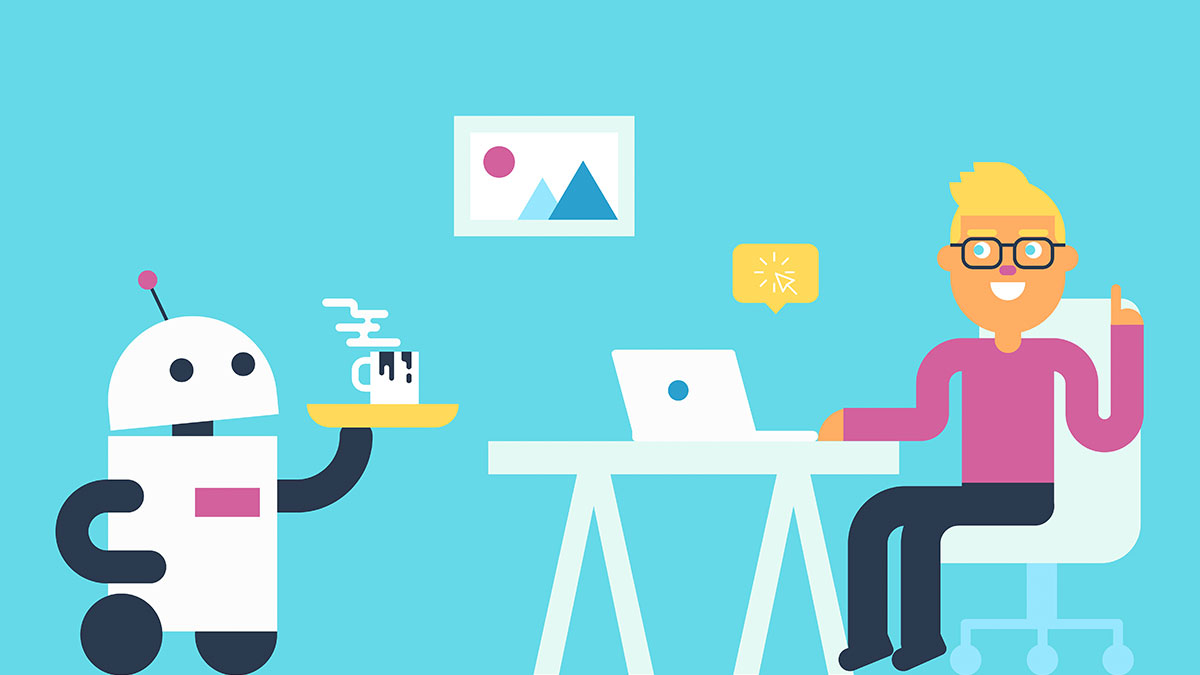

In [1]:
from IPython.display import Image
#Image("../input/image/image.jpg")

## <div id="SECTIONS">SECTIONS</div>

**<font size="2"><a href="#chap1">1. Set up</a></font>**
**<br><font size="2"><a href="#chap2">2. Data preprocessing</a></font>**
**<br><font size="2"><a href="#chap3">3. Feature Engineering</a></font>**
**<br><font size="2"><a href="#chap4">4. Modelling</a></font>**
**<br><font size="2"><a href="#chap5">5. Building the model</a></font>**
**<br><font size="2"><a href="#chap6">6. Submission</a></font>**

# <div id="chap1">1. Set up
## 1.1 Import the relevant libraries

In [2]:
#import some necessary librairies

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
%matplotlib inline
import matplotlib.pyplot as plt  # Matlab-style plotting
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)


from scipy import stats
from scipy.stats import norm, skew #for some statistics


pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) #Limiting floats output to 3 decimal points


from subprocess import check_output
print(check_output(["ls", "input"]).decode("utf8")) #check the files available in the directory

house-prices-advanced-regression-techniques
image



## 1.2 Load the data

In [3]:
#Now let's import and put the train and test datasets in  pandas dataframe

df_train = pd.read_csv("input/train.csv")
df_test = pd.read_csv("input/test.csv")

In [4]:
#check the numbers of samples and features
print("The train data size before dropping Id feature is : {} ".format(df_train.shape))
print("The test data size before dropping Id feature is : {} ".format(df_test.shape))

#Save the 'Id' column
train_ID = df_train['Id']
test_ID = df_test['Id']

#Now drop the  'Id' colum since it's unnecessary for  the prediction process.
df_train.drop("Id", axis = 1, inplace = True)
df_test.drop("Id", axis = 1, inplace = True)

#check again the data size after dropping the 'Id' variable
print("\nThe train data size after dropping Id feature is : {} ".format(df_train.shape)) 
print("The test data size after dropping Id feature is : {} ".format(df_test.shape))

The train data size before dropping Id feature is : (1460, 81) 
The test data size before dropping Id feature is : (1459, 80) 

The train data size after dropping Id feature is : (1460, 80) 
The test data size after dropping Id feature is : (1459, 79) 


The data have already been splitted into train and test set (apparently 50/50).
The missing column in the test set is the SalePrice, obviously !

# <div id="chap2">2. Data preprocessing
For now, we just want to preprocess the data a bit before starting to implement our pipeline.

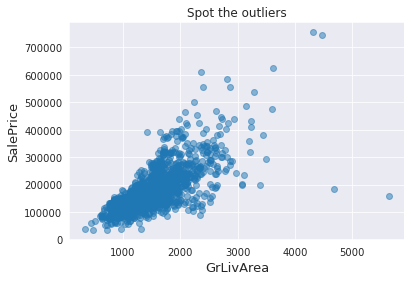

In [5]:
plt.figure()
plt.scatter(x = df_train['GrLivArea'], y = df_train['SalePrice'], alpha = 0.5)
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.title('Spot the outliers')
plt.show()

The two dots on the right of the graphs might be some outliers. These are huge houses but also cheap ones, let's remove them now.

In [6]:
df_train = df_train.drop(df_train[(df_train['GrLivArea']>4000) & (df_train['SalePrice']<210000)].index)

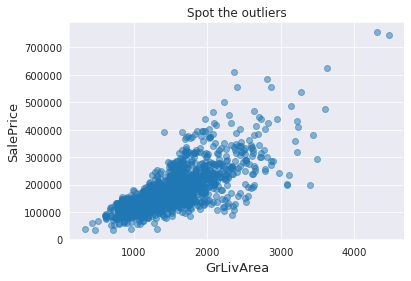

In [7]:
plt.figure()
plt.scatter(x = df_train['GrLivArea'], y = df_train['SalePrice'], alpha = 0.5)
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.title('Spot the outliers')
plt.show()

Perfect !


 mu = 180932.92 and sigma = 79467.79



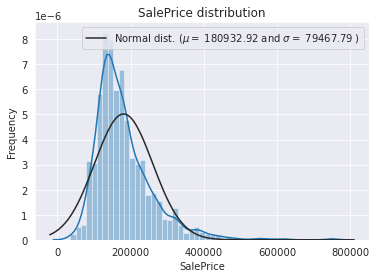

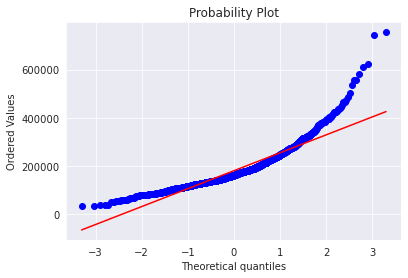

In [8]:
sns.distplot(df_train['SalePrice'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(df_train['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(df_train['SalePrice'], plot=plt)
plt.show()

We can claerly see on this graph that the SalePrice distribution is not normal at all. This is bad news since some linear models perform better on normal data. One transformation one can use to tackle this problem is the log(1+x),let's use it:


 mu = 12.02 and sigma = 0.40



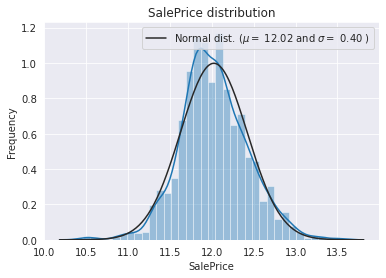

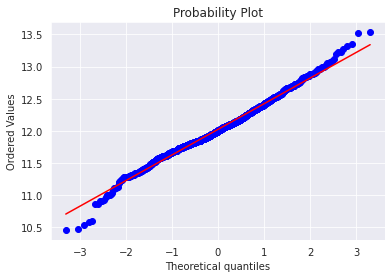

In [9]:
#We use the numpy fuction log1p which  applies log(1+x) to all elements of the column
df_train["SalePrice"] = np.log1p(df_train["SalePrice"])

#Check the new distribution 
sns.distplot(df_train['SalePrice'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(df_train['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(df_train['SalePrice'], plot=plt)
plt.show()

This is way better ! However, one have to pay attention to the final prediction...it's ganna be the log(1 + SalePrice), we'll need to re-transform it later, before the submission !

# <div id="chap3">3. Feature Engineering
Here we go for the pipeline ! One last thing we need to do before starting is to concatenate the train and test set. Why that ? Because I know from experience on this competition that for some features (columns) the train and test set doesn't have the exact same categorical values, let me show you !

In [10]:
train_feature_ext = df_train['Exterior1st'].value_counts().index
test_feature_ext = df_test['Exterior1st'].value_counts().index

print( 'The number of catogries in the train set for the "Extorior1st" feature is:  {:.0f}'.format(len(train_feature_ext)))
print( '\nThe number of catogries in the test set for the "Extorior1st" feature is:  {:.0f}'.format(len(test_feature_ext)))

The number of catogries in the train set for the "Extorior1st" feature is:  15

The number of catogries in the test set for the "Extorior1st" feature is:  13


For instance, for the Extorior1st feature, we got 15 categories for the train set and 13 for the test_set. This means that if we use an encoder separatly on the train and test set, the categories won't be encoded the same way and will resulst in a bad prediction.

In [11]:
ntrain = df_train.shape[0]
ntest = df_test.shape[0]

y_train = df_train['SalePrice']

all_data = pd.concat((df_train, df_test)).reset_index(drop=True) # all_data contains all the data from the train and test set expect for the SalePrice
all_data.drop(['SalePrice'], axis=1, inplace=True)
print("all_data size is : {}".format(all_data.shape))

all_data size is : (2917, 79)


## 3.2 Missing data
One big problem of this dataset is the missing data. Some columns are almost empty:

In [12]:
nbr_missing = all_data.isnull().sum()
all_data_na = (nbr_missing / len(all_data)) * 100

all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:40]
nbr_missing = nbr_missing.drop(nbr_missing[nbr_missing == 0].index).sort_values(ascending=False)[:40]

missing_data = pd.DataFrame({'Percent missing' :all_data_na, 'Missing values' :nbr_missing})
missing_data.head(40)

Percent missing  Missing values
PoolQC                 99.691            2908
MiscFeature            96.400            2812
Alley                  93.212            2719
Fence                  80.425            2346
FireplaceQu            48.680            1420
LotFrontage            16.661             486
GarageFinish            5.451             159
GarageYrBlt             5.451             159
GarageQual              5.451             159
GarageCond              5.451             159
GarageType              5.382             157
BsmtExposure            2.811              82
BsmtCond                2.811              82
BsmtQual                2.777              81
BsmtFinType2            2.743              80
BsmtFinType1            2.708              79
MasVnrType              0.823              24
MasVnrArea              0.788              23
MSZoning                0.137               4
BsmtFullBath            0.069               2
BsmtHalfBath            0.069               2
Utilities               0.069               2
Functional              0.069               2
Exterior2nd             0.034               1
Exterior1st             0.034               1
SaleType                0.034               1
BsmtFinSF1              0.034               1
BsmtFinSF2              0.034               1
BsmtUnfSF               0.034               1
Electrical              0.034               1
KitchenQual             0.034               1
GarageCars              0.034               1
GarageArea              0.034               1
TotalBsmtSF             0.034               1

Another way to visualize this lack of data is to display the whole dataset as followed:

Text(0.5, 1.0, 'Visual representation of the missing values in the dataset')

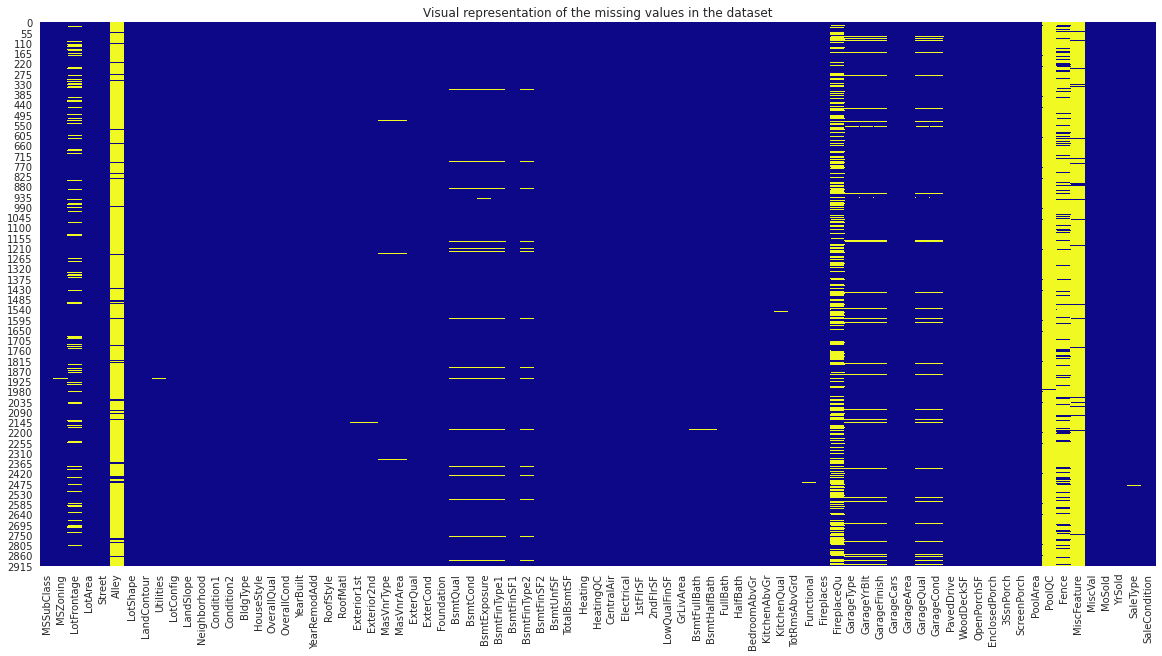

In [13]:
plt.figure(figsize=(20,10))
sns.heatmap(all_data.isna(), cbar=False, cmap = 'plasma')
plt.title('Visual representation of the missing values in the dataset')

This kind of representation is usefull to recognize some pattern in the lack of data. We can clearly see that all the "BsmtX" features lack the same amount of data. Same for the "GarageX" features. It's now time to deal with them.

In [14]:
from sklearn.base import BaseEstimator, TransformerMixin

class NaN_transformer(BaseEstimator, TransformerMixin):
    '''
    This transformer fill the missing values in the given dataset,
    or delete the features with too much missing values.
    '''

    def fit( self, X, y=None ):
        return self 

    def transform(self, X, y=None):
        
        X["PoolQC"] = X["PoolQC"].fillna("None") #PoolQC : data description says NA means "No Pool"
        X["MiscFeature"] = X["MiscFeature"].fillna("None") #MiscFeature : data description says NA means "no misc feature"
        X["Alley"] = X["Alley"].fillna("None") #Alley : data description says NA means "no alley access"
        X["Fence"] = X["Fence"].fillna("None") #Fence : data description says NA means "no fence""
        X["FireplaceQu"] = X["FireplaceQu"].fillna("None") #FireplaceQu : data description says NA means "no fireplace"
        
        for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
            X[col] = X[col].fillna('None')
        
        X['GarageYrBlt'] = X['GarageYrBlt'].fillna(X['GarageYrBlt'].median()) # We fill the missing data with the medianvalue of the other variables
        X['GarageCars'] = X['GarageCars'].fillna(0) # We fill the missing data with 0 cars
        X = X.drop('GarageArea', axis = 1) #'GarageCars' and 'GarageArea' are correlated variables, we'll keep only one
        
        X["LotFrontage"] = X.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))
        
        for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
            X[col] = X[col].fillna(0) # These samples are likely to have no basement, since the fill with zeros
            
        for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
            X[col] = X[col].fillna('None') # NaN means no basement
        
        X["MasVnrType"] = X["MasVnrType"].fillna("None")
        X["MasVnrArea"] = X["MasVnrArea"].fillna(0)
        
        X['MSZoning'] = X['MSZoning'].fillna(all_data['MSZoning'].mode()[0]) # Filling with the most common category
        
        X = X.drop(['Utilities'], axis=1)
        
        X["Functional"] = X["Functional"].fillna("Typ") #data description says NA means typical
        
        X['Electrical'] = X['Electrical'].fillna(X['Electrical'].mode()[0]) # Filling with the most common category
        X['KitchenQual'] = X['KitchenQual'].fillna(X['KitchenQual'].mode()[0])
        X['Exterior1st'] = X['Exterior1st'].fillna(X['Exterior1st'].mode()[0])
        X['Exterior2nd'] = X['Exterior2nd'].fillna(X['Exterior2nd'].mode()[0])
        X['SaleType'] = X['SaleType'].fillna(X['SaleType'].mode()[0])
        
        X['MSSubClass'] =  X['MSSubClass'].fillna("None")
        
        X['TotalSF'] = X['TotalBsmtSF'] + X['1stFlrSF'] + X['2ndFlrSF'] # Adding a feature
        
        return(X)

**Time for some explications** (if you've never seen this, do not panic !)

If you are not very familiar with classes, here is the basic things you need to know: "*class NaN_transformer(BaseEstimator, TransformerMixin)*":
   - **NaN_transformer** is the name of our new transformer.
   - Once it is defined, we can use it as any other sklearn transformer...thanks to the heredity of the classes "*BaseEstimator*" and "*TransformerMixin*"
   - *TransformerMixin* allows us to immediatly use the "fit_transform" method without defining it in our own transformer.
   - *BaseEstimator* allows use to use immediatly "set_params" and "get_params" methods.
    
"Why there isn't an "__init__" method defined here ?" -Because, in this particular case, we don't need to pass any argument to our transformer.

The input data in this transformer is defined as X.

The variable "y" is "none" since we won't perform any transformation on the target data here.

If you want to know why missing data are filled this way, I highly suggest you to check this [notebook](http://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard) and this [one](https://www.kaggle.com/pmarcelino/comprehensive-data-exploration-with-python) too.

Let's check if it worked:

In [15]:
tmp = all_data.copy() # make a copy of the dataframe to show an exemple

na_tr = NaN_transformer() #We pass nothing inside this transformer

tmp = na_tr.fit_transform(tmp)

Text(0.5, 1.0, 'Visual representation of the missing values in the dataset')

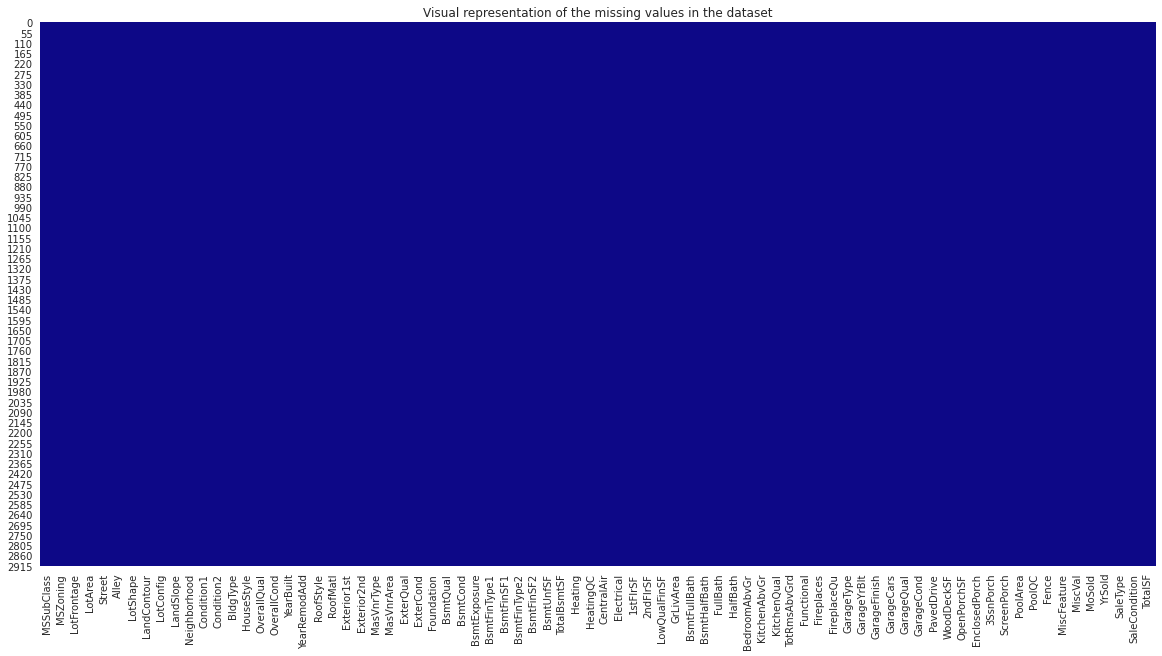

In [16]:
plt.figure(figsize=(20,10))
sns.heatmap(tmp.isna(), cbar=False, cmap = 'plasma')
plt.title('Visual representation of the missing values in the dataset')

Nice and blue !

## 3.3 Changing numericals to categoricals

Let's turn some numerical values to categorical ones with another transformer:

In [17]:
class ToCategorical_transformer(BaseEstimator, TransformerMixin):
    '''
    This transformer selects either numerical or categorical features.
    In this way we can build separate pipelines for separate data types.
    '''

    def fit( self, X, y=None ):
        return self 

    def transform(self, X, y=None):
        
        #MSSubClass=The building class
        X['MSSubClass'] = X['MSSubClass'].apply(str)

        #Changing OverallCond into a categorical variable
        X['OverallCond'] = X['OverallCond'].astype(str)

        #Year and month sold are transformed into categorical features.
        X['YrSold'] = X['YrSold'].astype(str)
        X['MoSold'] = X['MoSold'].astype(str)
        
        return(X)

In [18]:
tiny_tmp = all_data[['MSSubClass','OverallCond','YrSold','MoSold']]
tiny_tmp.dtypes

MSSubClass     int64
OverallCond    int64
YrSold         int64
MoSold         int64
dtype: object

In [19]:
toCat_tr = ToCategorical_transformer()

tiny_tmp = toCat_tr.fit_transform(tiny_tmp)

tiny_tmp.dtypes

MSSubClass     object
OverallCond    object
YrSold         object
MoSold         object
dtype: object

Great !
## 3.4 Label Encoding

In [20]:
from sklearn.preprocessing import LabelEncoder

cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold')

class Personal_LabelEncoder(BaseEstimator, TransformerMixin):
    '''
    This transformer selects either numerical or categorical features.
    In this way we can build separate pipelines for separate data types.
    '''
    def __init__(self, cols): #Now we need the __init__ method since we'll build variables we'll use in this transformer
        self.cols = cols # This variable will contains all the columns that will be transformed
        self.encoder = None # Since the encoder is already a transformer that exists, we'll define it in the fit method
    
    def fit( self, X, y=None ):
        self.encoder = LabelEncoder() # We fit the encoder to the data
        return self 

    def transform(self, X, y=None):
        for c in self.cols:
            X[c] = self.encoder.fit_transform(list(X[c].values)) # Here we actually do the transformation
        
        return(X)

In [21]:
tmp[['FireplaceQu', 'BsmtQual', 'BsmtCond']].head()

FireplaceQu BsmtQual BsmtCond
0        None       Gd       TA
1          TA       Gd       TA
2          TA       Gd       TA
3          Gd       TA       Gd
4          TA       Gd       TA

In [22]:
encoder = Personal_LabelEncoder(cols = cols)

tmp = encoder.fit_transform(tmp)

tmp[['FireplaceQu', 'BsmtQual', 'BsmtCond']].head()

FireplaceQu  BsmtQual  BsmtCond
0            3         2         4
1            5         2         4
2            5         2         4
3            2         4         1
4            5         2         4

It worked too !

## 3.5 Dummy transformation

In [23]:
from sklearn.base import BaseEstimator, TransformerMixin

class Dummy_transform(BaseEstimator, TransformerMixin):
    '''
    This transformer selects either numerical or categorical features.
    In this way we can build separate pipelines for separate data types.
    '''

    def fit( self, X, y=None ):
        return self 

    def transform(self, X, y=None):
        X = pd.get_dummies(X)
        return(X)

## 3.6 Putting everything together

In [24]:
from sklearn.pipeline import Pipeline

full_pipe= Pipeline([
                ('NaN transformer', NaN_transformer()),
                ('To categorical Transform', ToCategorical_transformer()),
                ('Label Encoder', Personal_LabelEncoder(cols = cols)),
                ('Dummy transformation', Dummy_transform())
            ])

all_data_tr = all_data.copy()

all_data_tr = full_pipe.fit_transform(all_data_tr)

In [25]:
all_data_tr.head()

MSSubClass  LotFrontage  LotArea  Street  Alley  LotShape  LandSlope  \
0          10       65.000     8450       1      1         3          0   
1           5       80.000     9600       1      1         3          0   
2          10       68.000    11250       1      1         0          0   
3          11       60.000     9550       1      1         0          0   
4          10       84.000    14260       1      1         0          0   

   OverallQual  OverallCond  YearBuilt  ...  SaleType_ConLw  SaleType_New  \
0            7            4       2003  ...               0             0   
1            6            7       1976  ...               0             0   
2            7            4       2001  ...               0             0   
3            7            4       1915  ...               0             0   
4            8            4       2000  ...               0             0   

   SaleType_Oth  SaleType_WD  SaleCondition_Abnorml  SaleCondition_AdjLand  \
0             0            1                      0                      0   
1             0            1                      0                      0   
2             0            1                      0                      0   
3             0            1                      1                      0   
4             0            1                      0                      0   

   SaleCondition_Alloca  SaleCondition_Family  SaleCondition_Normal  \
0                     0                     0                     1   
1                     0                     0                     1   
2                     0                     0                     1   
3                     0                     0                     0   
4                     0                     0                     1   

   SaleCondition_Partial  
0                      0  
1                      0  
2                      0  
3                      0  
4                      0  

[5 rows x 219 columns]

In [26]:
all_data_tr.shape #We have way more columns due to the dummy transformation

(2917, 219)

Time to rebuilt the train and test set now !

In [27]:
X_train = all_data_tr[:ntrain]
X_test = all_data_tr[ntrain:]

In [28]:
X_train.head()

MSSubClass  LotFrontage  LotArea  Street  Alley  LotShape  LandSlope  \
0          10       65.000     8450       1      1         3          0   
1           5       80.000     9600       1      1         3          0   
2          10       68.000    11250       1      1         0          0   
3          11       60.000     9550       1      1         0          0   
4          10       84.000    14260       1      1         0          0   

   OverallQual  OverallCond  YearBuilt  ...  SaleType_ConLw  SaleType_New  \
0            7            4       2003  ...               0             0   
1            6            7       1976  ...               0             0   
2            7            4       2001  ...               0             0   
3            7            4       1915  ...               0             0   
4            8            4       2000  ...               0             0   

   SaleType_Oth  SaleType_WD  SaleCondition_Abnorml  SaleCondition_AdjLand  \
0             0            1                      0                      0   
1             0            1                      0                      0   
2             0            1                      0                      0   
3             0            1                      1                      0   
4             0            1                      0                      0   

   SaleCondition_Alloca  SaleCondition_Family  SaleCondition_Normal  \
0                     0                     0                     1   
1                     0                     0                     1   
2                     0                     0                     1   
3                     0                     0                     0   
4                     0                     0                     1   

   SaleCondition_Partial  
0                      0  
1                      0  
2                      0  
3                      0  
4                      0  

[5 rows x 219 columns]

# <div id="chap4">4. Modelling
## 4.1 Import the relevant libraries

In [29]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, BaggingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.linear_model import ElasticNet, ElasticNetCV, Lasso, LinearRegression, BayesianRidge
from sklearn.svm import SVR
from mlxtend.regressor import StackingCVRegressor
import lightgbm as lgb
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error

## 4.2 Defining usefull functions: score, cross_validation

In [30]:
# Setup cross validation folds
kf = KFold(n_splits=6, random_state=42, shuffle=True) #Because there are no shuffle implemented with the cross validation, we define here the folds for the cross validation

In [31]:
# Define error metrics
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

def cv_rmse(model, X=X_train):
    rmse = np.sqrt(-cross_val_score(model, X.values, y_train.values, scoring="neg_mean_squared_error", cv=kf))
    return (rmse)

## 4.3 Defining the models
we'll define several models and select the ones that performs better

### Linear regressor
ok this one, I'll assume you already know it !

In [32]:
linear = make_pipeline(RobustScaler(),LinearRegression())

### Lasso regressor
- The idea behing lasso regression is to add a penalty to the sum of the least squared residuals using a lambda coefficient that multiplies the absolute value of the slope of the fitting line.
- Usually, by decreasing the sum of the least squares we are getting a line that fits the data better. The thing is that this line might predict well the training data but badly the test data. By using a penalty lambda coefficient, we increase the bias for the training line but at the end of the day, we are decreasing the variance of the fit on the test data.
- Lasso regression is very similar to ridge regression. The difference is that with ridge, we take the square of the slope and not the absolute value.
- The lambda parameter is determined with a cross validation. If lambda = 0, the lasso line is the same as the least square line calculated with a Linear Regression.
- The nice thing with using lasso regression is that we can get rid of useless features with a proper lambda.
For this competition, since we have plenty of features that might not be that usefull, lasso regression seems a better choice in comparison to ridge regression that doesn't get completly get rid of useless variables.

Now that we have seen how to build and use a pipeline to clean the data you might want to know how to build a pipeline with models inside, well, it is as simple as before ! Sice we haven't scaled the data yet, we have to do it before calling the model. This is where the pipeline will be usefull. We'll build a "new model" that is a succession of a scaler and the model:

In [33]:
# Here the lambda parameter is called "alpha"
lasso = make_pipeline(StandardScaler(), Lasso(alpha =0.0035, random_state=42)) # Here lasso_pipe has to be used just like a regular model.

In [34]:
# But...what if we want to try different scaler, how to use GridSearchCV with a pipeline ???
# Check this out:

lasso_pipe = Pipeline([ #We have to create a pipeline, just like before, but create a "None" value for the scaler that we will fill later.
    ('scaler', None),
    ('classifier', Lasso())
])

alpha_params = [0.0025,0.003,0.0035]

# Now we have to define a list of dictionnary. Within each dictionnary we'll call a different scaler and the same alpha parameters
param_grid = [
    {
        'scaler': [StandardScaler()],
        'classifier__alpha': alpha_params,
    },
    {
        'scaler': [RobustScaler()],
        'classifier__alpha': alpha_params,
    },
]

#Then, well, you already know how to build a grid !

lasso_grid = GridSearchCV(lasso_pipe, param_grid, cv=kf)
lasso_grid.fit(X_train, y_train)

print('the best score obtained is {} with the parameters {}'.format(lasso_grid.best_score_,lasso_grid.best_params_))

the best score obtained is 0.9173135188173357 with the parameters {'classifier__alpha': 0.0035, 'scaler': StandardScaler()}


### ElasticNet regressor
- The ElasticNet regression is a mix between the ridge and the lasso regression. (The good news is that we already know the main ideas behind lasso regression and have some insight on how ridge regression works).
- It is a good choice when one have to many features (so many that one cannot interpret all of them). This is not the case here but why not try it and see what happen ?
- The important thing here is that there are two penalty lambda parameters now (one like the lasso and one like the ridge). However in sklearn, these parameters are controlled with the parameters "alpha" and "l1_ratio".

a * L1 + b * L2 where alpha = a + b and l1_ratio = a / (a + b).

In [35]:
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0045, l1_ratio=.9, random_state=3))

In [36]:
ENet_pipe = Pipeline([ #We have to create a pipeline, just like before, but create a "None" value for the scaler that we will fill later.
    ('scaler', None),
    ('classifier', ElasticNet())
])

alpha_params = [0.00045,0.0005,0.00055]
l1_params = [0.85,0.86,0.87,0.88,0.89,0.9]

# Now we have to define a list of dictionnary. Within each dictionnary we'll call a different scaler and the same alpha parameters
param_grid = [
    {
        'scaler': [StandardScaler()],
        'classifier__alpha': alpha_params,
        'classifier__l1_ratio': l1_params,
    },
    {
        'scaler': [RobustScaler()],
        'classifier__alpha': alpha_params,
        'classifier__l1_ratio': l1_params,
    },
]

#Then, well, you already know how to build a grid !

ENet_grid = GridSearchCV(ENet_pipe, param_grid, cv=kf)
ENet_grid.fit(X_train, y_train)

print('the best score obtained is {} with the parameters {}'.format(ENet_grid.best_score_,ENet_grid.best_params_))

the best score obtained is 0.9187914714607679 with the parameters {'classifier__alpha': 0.00045, 'classifier__l1_ratio': 0.9, 'scaler': RobustScaler()}


### Random Forest Regressor
Here I'll assume you have some basic knowledge about RandomForest Regressor but just as a reminder (because we'll need this for other models):
- **n_estimator**: Represents the number of trees that will be created.
- **min_sample_split**: Specifies the minimum number of samples requiered to split an internal node;
- **min_sample_leaf**: Specifies the minimum number of sample requiered to be a leaf node;
- **max_depth**: Represents the depth of each tree in the forest. The deeper the trees, the more it captures information about the input data.
- **max_features**: represents the number of features to consider when looking for the best split
    - sqrt: max_feature = sqrt(n_features)
    - None: max_feature = n_features
    - log2: max_feature = log2(n_features)
- **random_state**: Control both randomness of the boostrapping and the sampling of the features to consider when looking for the best split at each node.

In [37]:
# Random Forest Regressor
rf = RandomForestRegressor(n_estimators=1200,
                          max_depth=15,
                          min_samples_split=5,
                          min_samples_leaf=5,
                          max_features=None,
                          oob_score=True,
                          random_state=42)

### AdaBoostRegressor

To uderstand how AdaBoostRegressors work, it is a good thing to compare it to a RandomForest models.
- In comparison to RandomForest, where trees are developped to their maximum depth (or close to it), trees made with Adaboost are just composed of a node and two leaves (this is called a "stump"). AdaBoost models create a forest of stumps.
- In RandomForest,each tree's vote is the same worth for the final prediction, this is not the case with AdaBoost where some stumps have more say in the final prediction. The amount of say is related to the ability of the stump to correct the errors made on previous ones.
- In RandomForest, each trees are build independently, this is not the case in AdaBoost. The order of creation of the stumps is important. The error that one stump made influence the next stump and so on.
- The **learning_rate** is used here to prevent the model to fit the data to well (to start overfitting the data).


In [38]:
adar = AdaBoostRegressor(n_estimators=4000,
                         learning_rate=0.01,
                         loss='linear',
                        random_state=42,)

We've seen how to use GridSearchCV on the previous exemples, now that models are becoming more and more sophisticated, it might be too long to wait for a full grid to run if we want to fine tune a model. One thing one can try is to use a RandomizedSearchCV that will try, randomly, a certain amount of combinaison. It can be a good choice to gain a first insight on the scale of the parameters you have to tune.

In [39]:
param_grid={
    'n_estimators':[4000],
    'learning_rate':[0.001,0.005,0.01],
    'loss':['linear','exponential']
    
    
}
adar_grid = RandomizedSearchCV(AdaBoostRegressor(random_state=42), param_grid, cv=kf) # Just use it like a regular GridSearchCV
adar_grid.fit(X_train,y_train)

RandomizedSearchCV(cv=KFold(n_splits=6, random_state=42, shuffle=True),
                   estimator=AdaBoostRegressor(random_state=42),
                   param_distributions={'learning_rate': [0.001, 0.005, 0.01],
                                        'loss': ['linear', 'exponential'],
                                        'n_estimators': [4000]})

In [40]:
adar_grid.best_score_ # This is how to access the best score calculated

0.8301930012697264

In [41]:
adar_grid.best_params_ # This is how to get the parameters that leads to the best score

{'n_estimators': 4000, 'loss': 'exponential', 'learning_rate': 0.005}

In [42]:
model_adar = adar_grid.best_estimator_ # This is how to create a new model with the best parameters found in the grid.

In [43]:
score = cv_rmse(model_adar)
print("model_adar: {:.4f} ({:.4f})".format(score.mean(), score.std()))
#scores['model_adar'] = (score.mean(), score.std())

model_adar: 0.1643 (0.0064)


### Gradient Boosting Regressor
In order to understand the main ideas behind a GradientBoostingRegressor, it is best to know how AdaBoostRegressors work...what a chance, you know it now !

- In contrast to AdaBoost, GradientBoost starts by making a single leaf and not a Stump (the first leaf is the average of the y values)
- Then a tree is made from this leaf. Usually, this tree is larger than a Stump. And just like AdaBoost, each tree is made based on the errors of the previous one.

In [44]:
gbr = GradientBoostingRegressor(n_estimators=3000,
                                learning_rate=0.01,
                                max_depth=4,
                                max_features='sqrt',
                                min_samples_leaf=15,
                                min_samples_split=10,
                                loss='huber',
                                random_state=42)

### XGBoost regressor
XGBoost stands for "eXtreme Gradient Boosting" (sounds fancy right ?), let's say it is just an advanced implementation of gradient boosting algorithm and let's focus on the parameters. One last thing important to know is that XGBoost algorithms are not in the SKlearn library, these algorithms come from a specific library (xgboost) but use the same API as SKlearn.
There are a lot of parameters to tune on the XGBoost, hence the difficulty to fine tune it well. Among these, you already know lot of them (learning_rate, n_estimators, max_depth etc. so I won't (re)cover them, let's focus on the new ones:
- **min_child_weight**: Defines the minium sum of instances of all observations requiered in a child. In the particular case of linear regression, it correponds to the number of instances needed to be in each node. This value ranges from 0 to infinity.
- **gamma**: A node is split only when the resulting split gives a positive reduction in the loss function. Gamma specifies the minimum loss reduction requiered to make a split.
- **subsample**: This is the percentage of observations to be randomly samples for each tree.
- **colsample_bytree**: the percentage of features to be considered when creating a new tree
- **alpha**: This is just like in the lasso regression, the L1 regularization term on weight
- **objective**: This defines the loss function to be minimized. Here we use the RMSE since it is a regression problem

These are just some of the parameters, there are a lot more but since it is difficult enough to fine tune it, I'll stick with these ones. For more information you can visit the XGBoost documentation [here](https://xgboost.readthedocs.io/en/latest/parameter.html).

In [45]:
# XGBoost Regressor
xgboost = XGBRegressor(learning_rate=0.01,
                       n_estimators=7000,
                       max_depth=8,
                       min_child_weight=10,
                       gamma=0.6,
                       subsample=0.5,
                       colsample_bytree=0.7,
                       objective='reg:squarederror',
                       nthread=-1,
                       seed=42,
                       reg_alpha=0.006,
                       random_state=42)

### LightGradientBoosting regressor
This is again a kind of Boosting Regressors not directly implemented in SKlearn but that uses the same API. It is pretty similar to the basic gradient boosting regressor but is said to be faster in training, better in accuracy and uses less memory.

For more information, go to this [page](https://lightgbm.readthedocs.io/en/latest/Parameters.html) that is the documentation of the LGBMRegressor.

In [46]:
# Light Gradient Boosting Regressor
lightgbm = LGBMRegressor(objective='regression', 
                       num_leaves=6,
                       learning_rate=0.01, 
                       n_estimators=7000,
                       max_bin=200, # This is the maximum number of bins the features will be bucketed in.
                       bagging_fraction=0.8,
                       bagging_freq=4, # Means: perform the bagging every 4 iterations
                       bagging_seed=42, # Equivalent of random_state but with bagging.
                       feature_fraction=0.2, # As usual, the faction of features that will be randomly selected to build trees at each iteration
                       feature_fraction_seed=42, # Equivalent of random_state but with the feature_fraction
                       min_sum_hessian_in_leaf = 11,
                       verbose=-1, # To shut down the messages
                       random_state=42)

### Support Vector Regressor
This is regressor is part of the support vector machine algorithms. To really understand how support vector machine works you have to go deeper in the math. However, I'll try to give a vague idea of what you have to know. This kind of estimator relies on defining a loss function that ignores errors for all the points located inside a tube (a tube of k dimensions depending on the problem) that encapsulate the true value. The value **epsilon** we have to define as a parameter for the SVR is the width of the tube.
- **C** is used for regularization, this is a L2 suared penalty.

In [47]:
# Support Vector Regressor
svr = make_pipeline(StandardScaler(), SVR(C= 5, epsilon= 0.0003, gamma=0.0003))

In [48]:
svr_pipe = Pipeline([ #We have to create a pipeline, just like before, but create a "None" value for the scaler that we will fill later.
    ('scaler', None),
    ('classifier', SVR())
])

C_params = [4,5,6]
epsilon_params = [0.0002,0.0003,0.0004,0.0005]
gamma_params = [0.00005,0.0001,0.0002,0.0003]

param_grid ={
        'scaler': [StandardScaler()],
        'classifier__C': C_params,
        'classifier__epsilon': epsilon_params,
        'classifier__gamma': gamma_params,
    }

svr_grid = GridSearchCV(svr_pipe, param_grid, cv=kf)
svr_grid.fit(X_train, y_train)

print('the best score obtained is {} with the parameters {}'.format(svr_grid.best_score_,svr_grid.best_params_))

model_svr = svr_grid.best_estimator_

the best score obtained is 0.9135826901148781 with the parameters {'classifier__C': 5, 'classifier__epsilon': 0.0003, 'classifier__gamma': 0.0003, 'scaler': StandardScaler()}


In [49]:
score = cv_rmse(model_svr)
print("xgboost: {:.4f} ({:.4f})".format(score.mean(), score.std()))
#scores['xgboost'] = (score.mean(), score.std())

xgboost: 0.1169 (0.0079)


### Stacking models
This is the ultimate trick you want to know, to make our prediction more robust and to get the best of every single model we've made so far, we can use a StackingCVRegressor that will combine multiple models via a meta-regressor.

Here we are using the StackingCVRegressor which is a more advanced ensemble technique implemented in SKlearn, StackingRegressor (but if you understand how this one works, you won't have any trouble for the easiest !).

With this stacking technique, all the models specified in **regressors** are trained on k-1 folds of the data (CV in the name obviously stands for CrossValidation, hence the spits into k folds). Once there are trained, the prediction is made based on the last fold and is used as input data for the meta-regressor. This is repeated on the entire dataset.

Here, since **use_features_in_secondary**=True, the meta-regressor will be trained on both the predictions from the regressors and the original dataset.

In [50]:
#Stack up all the models above, optimized using xgboost
stack_gen = StackingCVRegressor(regressors=(xgboost, lightgbm, svr, ENet, lasso, rf),
                                meta_regressor=xgboost,
                                use_features_in_secondary=True)

## Evaluation of the models
Now time to see how well models performed. As a reminder, we are using a shuffled 6-fold cross validation to evaluate them.

In [51]:
scores = {}

score = cv_rmse(linear)
print("linear: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['linear'] = (score.mean(), score.std())

linear: 0.1253 (0.0084)


In [52]:
score = cv_rmse(lasso)
print("lasso: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['lasso'] = (score.mean(), score.std())

lasso: 0.1144 (0.0086)


In [53]:
score = cv_rmse(ENet)
print("ENet: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['ENet'] = (score.mean(), score.std())

ENet: 0.1241 (0.0116)


In [54]:
score = cv_rmse(lightgbm)
print("lightgbm: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['lightgbm'] = (score.mean(), score.std())

lightgbm: 0.1174 (0.0094)


In [55]:
score = cv_rmse(xgboost)
print("xgboost: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['xgboost'] = (score.mean(), score.std())

xgboost: 0.1387 (0.0102)


In [56]:
score = cv_rmse(gbr)
print("gbr: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['gbr'] = (score.mean(), score.std())

gbr: 0.1135 (0.0101)


In [57]:
score = cv_rmse(rf)
print("rf: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['rf'] = (score.mean(), score.std())

rf: 0.1393 (0.0102)


## Fit the models to the whole dataset
If you are now satified with the root-mean-squared error of every model (once you fine tuned them for hours !) it is time to fit them to the whole dataset. Previously, all we did was just to find the best parameters for each models to compare them. Here things are getting serious !

In [58]:
print('stack_gen')
stack_gen_model = stack_gen.fit(np.array(X_train), np.array(y_train))

stack_gen


In [59]:
print('lightgbm')
lgb_model_full_data = lightgbm.fit(X_train, y_train)

lightgbm


In [60]:
print('xgboost')
xgb_model_full_data = xgboost.fit(X_train, y_train)

xgboost


In [61]:
print('linear')
linear_model_full_data = linear.fit(X_train, y_train)

linear


In [62]:
print('lasso')
lasso_model_full_data = lasso.fit(X_train, y_train)

lasso


In [63]:
print('Svr')
svr_model_full_data = svr.fit(X_train, y_train)

Svr


In [64]:
print('RandomForest')
rf_model_full_data = rf.fit(X_train, y_train )

RandomForest


In [65]:
print('GradientBoosting')
gbr_model_full_data = gbr.fit(X_train, y_train)

GradientBoosting


To make the prediction as accurate as possible, we'll mix the results of every models based on how well they performed lately. Since we are predicting prices (continuous variable) we can add part of the predictions as we want (the total of percentage coefficient must be 1 obviously). 

In [66]:
# Blend models in order to make the final predictions more robust to overfitting
def blended_predictions(x1,x2,x3,x4,x5,x6,x7,X):
    assert(x1+x2+x3+x4+x5+x6+x7 == 1.0, 'Sum is not equal to 1')
    return ((x1 * lasso_model_full_data.predict(X)) + \
            (x2 * svr_model_full_data.predict(X)) + \
            (x3 * gbr_model_full_data.predict(X)) + \
            (x4 * xgb_model_full_data.predict(X)) + \
            (x5 * lgb_model_full_data.predict(X)) + \
            (x6 * rf_model_full_data.predict(X)) + \
            (x7 * stack_gen_model.predict(np.array(X))))

<>:3: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<>:3: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<>:3: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<ipython-input-66-1e8165024937>:3: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert(x1+x2+x3+x4+x5+x6+x7 == 1.0, 'Sum is not equal to 1')


In [67]:
x1, x2, x3, x4, x5, x6, x7 = 0.3, 0.1, 0.05, 0.1, 0.3, 0.1, 0.05

Now it is your turn to optimize these parameters to get the best results !

In [68]:
# Get final precitions from the blended model
blended_score = rmsle(y_train, blended_predictions(x1,x2,x3,x4,x5,x6,x7,X_train))
scores['blended'] = (blended_score, 0)
print('RMSLE score on train data:')
print(blended_score)

RMSLE score on train data:
0.07638910678103546


Let's see how well each model performed compared to the blended model:

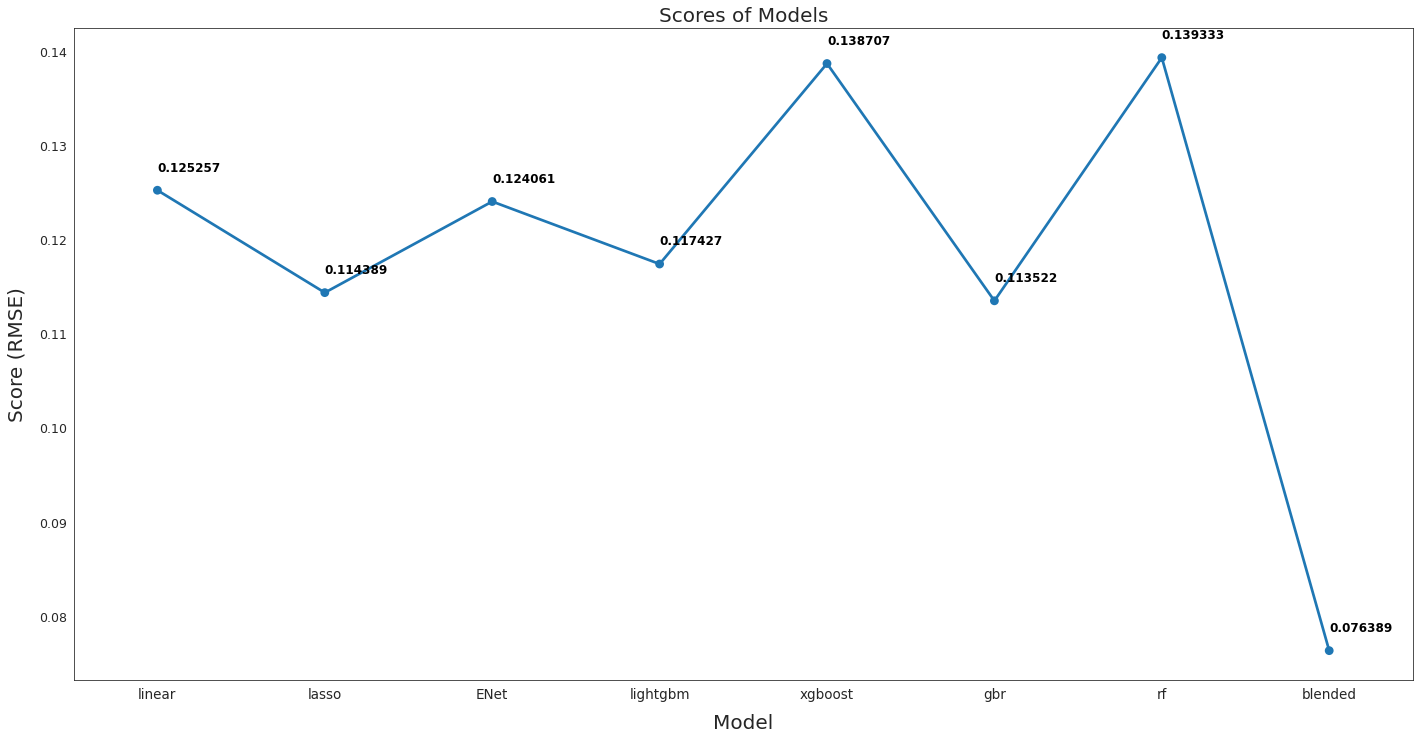

In [69]:
# Plot the predictions for each model
sns.set_style("white")
fig = plt.figure(figsize=(24, 12))

ax = sns.pointplot(x=list(scores.keys()), y=[score for score, _ in scores.values()], markers=['o'], linestyles=['-'])
for i, score in enumerate(scores.values()):
    ax.text(i, score[0] + 0.002, '{:.6f}'.format(score[0]), horizontalalignment='left', size='large', color='black', weight='semibold')

plt.ylabel('Score (RMSE)', size=20, labelpad=12.5)
plt.xlabel('Model', size=20, labelpad=12.5)
plt.tick_params(axis='x', labelsize=13.5)
plt.tick_params(axis='y', labelsize=12.5)

plt.title('Scores of Models', size=20)

plt.show()

Looks like this technique works well !

# <div id="chap6">6. Submission

In [70]:
sub = pd.DataFrame()
sub['Id'] = test_ID
sub['SalePrice'] = np.expm1(blended_predictions(x1,x2,x3,x4,x5,x6,x7,X_test))
sub.to_csv('submission_house_price.csv',index=False)

# This is already the end of this notebook, if you found it useful, please consider leaving an upvote. If you want more details or comments on one specific point, leave a comment, I'll try my best to give you an answer !